# XGBoost Prototype
This notebook will be used to develop a prototype machine learning model to be used for fitting the from the strain gauges for force reconstruction.
At first the prototype is going to be developed using the dataset found at https://www.kaggle.com/daalgi/fem-simulations

## Introduction
This first section introduces the general idea of what is going to be done and takes care of some housekeeping tasks like imports.
The following cell imports the libraries we need for the model

In [56]:
## Imports
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

Now the data needs to be loaded in. We are in a colab notebook, so the data is loaded as follows from a local drive which has to have the data already in it.

In [2]:
## Loading in data
from google.colab import files
uploaded = files.upload()

Saving 5184doe.csv to 5184doe.csv



In the previous step, we loaded the file from the drive into the colab workspace, and now we transform it into a data type called a "dataframe" which is easy to think of essentially as an excel table, with headers and all. The library that handles the dataframe data type is pandas, shortened to "pd" in the imports. The variable that stores this data is "df".

The step of loading in the data is so simple because we are getting a dataset which is already very well formated. Whenever we get the actual dataset a lot will have to be done to pre-process it and create a dataset which is usable by the model.

In [9]:
## load data into variable
df = pd.read_csv('5184doe.csv')

# display the dataframe variable
df

,Sample,ecc,N,gammaG,Esoil,Econc,Dbot,H1,H2,H3,Mr_t,Mt_t,Mr_c,Mt_c
0,1,0,2000,0.9,25,30000,17,0.8,1.0,0.8,0.082100,0.055648,0.082100,0.055648
1,2,10,2000,0.9,25,30000,17,0.8,1.0,0.8,-0.597084,-0.233470,1.160648,0.605016
2,3,18,2000,0.9,25,30000,17,0.8,1.0,0.8,-1.094196,-0.566130,1.908188,0.947770
3,4,26,2000,0.9,25,30000,17,0.8,1.0,0.8,-1.416485,-0.865039,2.844706,1.310545
4,5,0,2000,0.9,25,37000,17,0.8,1.0,0.8,0.079570,0.054213,0.079570,0.054213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5179,5180,26,5000,1.1,75,30000,23,1.6,2.0,1.6,-6.027412,-2.866107,6.471047,4.499262
5180,5181,0,5000,1.1,75,37000,23,1.6,2.0,1.6,0.143146,0.108935,0.143146,0.108935
5181,5182,10,5000,1.1,75,37000,23,1.6,2.0,1.6,-2.671362,-0.561849,1.702752,2.465506
5182,5183,18,5000,1.1,75,37000,23,1.6,2.0,1.6,-4.408298,-1.696514,4.021527,3.522614


The headers aren't very descriptive, but reading the dataset description:
- load parameters: ecc, N, gammaG.
- material parameters: Esoil, Econc.
- geometry parameters: Dbot, H1, H2, H3.
- stress related results: Mrt, Mtt, Mrc, Mtc.

Knowing this, we can decide on what is going to be used for the input and what is going to be used for the output. 

It is desirable to keep the prototype as close as possible to the final model. The final model should have this behaviour (on prediction):

$$ 
f: \text{(strain gauge voltages)} \mapsto \text{(wheel hub loads)}
$$
Therefore the closest that can be achieved with the prototype for this dataset being naive and not trying to figure out how to exclude geometry parameters is to simply include the material and geometry parameters in the model, such that it behaves like this
$$ 
f: (E_{soil}, E_{conc}, D_{bot}, H_1, H_2, H_3, M_{rt}, M_{tt}, M_{rc}, M_{tc}) \mapsto (e_{cc}, N, \gamma_g)
$$

## Data investigation and split
It is good to investigate the dataset a little to better understand what type of data is in it, and then split it into the input and output of the model

In [7]:
# showing data types and number of empty entries
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5184 entries, 0 to 5183
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sample  5184 non-null   int64  
 1   ecc     5184 non-null   int64  
 2   N       5184 non-null   int64  
 3   gammaG  5184 non-null   float64
 4   Esoil   5184 non-null   int64  
 5   Econc   5184 non-null   int64  
 6   Dbot    5184 non-null   int64  
 7   H1      5184 non-null   float64
 8   H2      5184 non-null   float64
 9   H3      5184 non-null   float64
 10  Mr_t    5184 non-null   float64
 11  Mt_t    5184 non-null   float64
 12  Mr_c    5184 non-null   float64
 13  Mt_c    5184 non-null   float64
dtypes: float64(8), int64(6)
memory usage: 567.1 KB


In [8]:
## showing general statistics for the dataset parameters
df.describe()

,Sample,ecc,N,gammaG,Esoil,Econc,Dbot,H1,H2,H3,Mr_t,Mt_t,Mr_c,Mt_c
count,5184.000000,5184.000000,5184.000000,5184.00000,5184.000000,5184.000000,5184.000000,5184.00000,5184.000000,5184.00000,5184.000000,5184.000000,5184.000000,5184.000000
mean,2592.500000,13.500000,3500.000000,1.00000,50.000000,33500.000000,20.000000,1.20000,1.500000,1.20000,-1.629734,-0.810779,2.650433,1.518741
std,1496.636228,9.631609,1500.144697,0.10001,25.002412,3500.337626,2.449726,0.32663,0.408288,0.32663,1.426607,0.859657,2.475025,1.226075
min,1.000000,0.000000,2000.000000,0.90000,25.000000,30000.000000,17.000000,0.80000,1.000000,0.80000,-6.027412,-2.968574,0.024414,0.014080
25%,1296.750000,7.500000,2000.000000,0.90000,25.000000,30000.000000,17.000000,0.80000,1.000000,0.80000,-2.402849,-1.191169,0.251651,0.458440
50%,2592.500000,14.000000,3500.000000,1.00000,50.000000,33500.000000,20.000000,1.20000,1.500000,1.20000,-1.554450,-0.620024,2.138881,1.349318
75%,3888.250000,20.000000,5000.000000,1.10000,75.000000,37000.000000,23.000000,1.60000,2.000000,1.60000,-0.176328,0.018693,3.716968,2.413945
max,5184.000000,26.000000,5000.000000,1.10000,75.000000,37000.000000,23.000000,1.60000,2.000000,1.60000,0.251917,0.201895,9.408445,4.585227


Now we split the data into two datasets. It is common practice to call the inputs of a machine learning model "X", and the target/output of the model "y", however for the sake of making the model more readable in the future, I'm going to use "voltages" for the inputs and "forces" for the outputs/targets, even though the dataset we're using to develop the prototype has nothing to do with voltages.

In [15]:
# splitting dataset into input and output
voltages, forces = df.iloc[:,4:], df.iloc[:,1:4] #voltages are all rows of columns after the fourth, 
                                                 #and forces are all rows of columns before the fourth except for the first  

# displaying voltages for a sanity check that we got the correct columns
voltages

,Esoil,Econc,Dbot,H1,H2,H3,Mr_t,Mt_t,Mr_c,Mt_c
0,25,30000,17,0.8,1.0,0.8,0.082100,0.055648,0.082100,0.055648
1,25,30000,17,0.8,1.0,0.8,-0.597084,-0.233470,1.160648,0.605016
2,25,30000,17,0.8,1.0,0.8,-1.094196,-0.566130,1.908188,0.947770
3,25,30000,17,0.8,1.0,0.8,-1.416485,-0.865039,2.844706,1.310545
4,25,37000,17,0.8,1.0,0.8,0.079570,0.054213,0.079570,0.054213
...,...,...,...,...,...,...,...,...,...,...
5179,75,30000,23,1.6,2.0,1.6,-6.027412,-2.866107,6.471047,4.499262
5180,75,37000,23,1.6,2.0,1.6,0.143146,0.108935,0.143146,0.108935
5181,75,37000,23,1.6,2.0,1.6,-2.671362,-0.561849,1.702752,2.465506
5182,75,37000,23,1.6,2.0,1.6,-4.408298,-1.696514,4.021527,3.522614


## Regressor 
Most regression algorithms in machine learning use a single regression value. This presents a problem since our objective is to predict at least 3 values for the force $(x,y,z)$. There are several ways to circumvent this issue, and neural networks/deep learning models handle this natively, but for our problem likely the simplest is to wrap the model in a multioutput wrapper such as `sklearn.multioutput.MultiOutputRegressor`. [This seems to be the current supported method as per the xgboost github.](https://github.com/dmlc/xgboost/issues/2087).

In [29]:
## Defining regressors

# simple xgboost regressor
single_model = xgb.XGBRegressor(n_estimators=2000, max_depth=20, learning_rate=0.01)
print(single_model)

# multi output regressor
model = MultiOutputRegressor(single_model)
print("\n")
print(model)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=20, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)


MultiOutputRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            importance_type='gain',
                                            learning_rate=0.01,
                                            max_delta_step=0, max_depth=20,
                         

In [31]:
# fitting
multioutputregressor = model.fit(voltages, forces)

[02:47:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:47:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:47:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [33]:
# prediction
preds = model.predict(voltages)
preds = np.array(preds)
preds

array([[5.0961971e-06, 3.4999878e+03, 9.0029275e-01],
       [9.9999771e+00, 1.9999940e+03, 9.0010095e-01],
       [1.7999866e+01, 1.9999940e+03, 8.9997303e-01],
       ...,
       [1.0000171e+01, 4.9999756e+03, 1.1003637e+00],
       [1.7999958e+01, 4.9999761e+03, 1.0998728e+00],
       [2.5999891e+01, 4.9999761e+03, 1.0999899e+00]], dtype=float32)

## Evaluating
A good way of visualizing the performance of the model is to use the mean squared error with each of the force parameters when compared to the model predictions. 

mean squared error: 9.445673217526552e-09


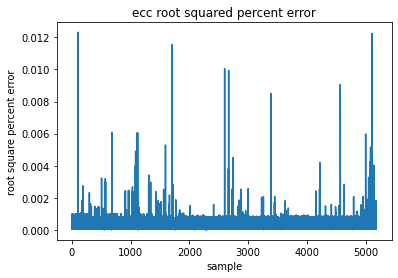

In [77]:
# the root squared error for ecc
rse_ecc = np.sqrt((preds[:,0] - np.array(df['ecc']))**2)

# the squared error percentage compared to the mean
rse_perc_ecc = (rse_ecc/df['ecc'].mean())*100
plt.plot(rse_perc_ecc)
plt.title('ecc root squared percent error')
plt.ylabel('root square percent error')
plt.xlabel('sample')

# the mean squared error
mse_ecc = mean_squared_error(preds[:,0],np.array(df['ecc']))
print(f'mean squared error: {mse_ecc}')

mean squared error: 562500.0002617456


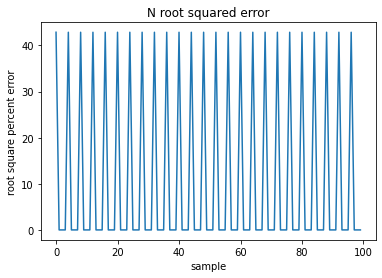

In [81]:
# the root squared error for N
rse_N = np.sqrt((preds[:,1] - np.array(df['N']))**2)

# the squared error percentage compared to the mean
rse_perc_N = (rse_N/df['N'].mean())*100
plt.plot(rse_perc_N[0:100], '-')
plt.title('N root squared error')
plt.ylabel('root square percent error')
plt.xlabel('sample')

# the mean squared error
mse_N = mean_squared_error(preds[:,1],np.array(df['N']))
print(f'mean squared error: {mse_N}')

mean squared error: 2.7758863901639538e-06


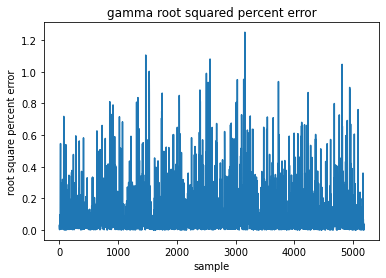

In [75]:
# the root squared error for N
rse_gamma = np.sqrt((preds[:,2] - np.array(df['gammaG']))**2)

# the squared error percentage compared to the mean
rse_perc_gamma = (rse_gamma/df['gammaG'].mean())*100
plt.plot(rse_perc_gamma)
plt.title('gamma root squared percent error')
plt.ylabel('root square percent error')
plt.xlabel('sample')

# the mean squared error
mse_gamma = mean_squared_error(preds[:,2],np.array(df['gammaG']))
print(f'mean squared error: {mse_gamma}')

So for both $e_{cc}$ and $\gamma_G$ the model was very performant, with maximum percent errors of 0.012% and 1.2% w.r.t their mean values, respectively. $N$ was problematic and although most of the error values seem to be very low (~0.2), it very often is wrong on the order of about 1500. Again, I don't know what $N$ is but it might just be that it is a value that isn't strongly correlated with the inputs.

## Tuning
It is worth it to devote some time to tuning after figuring out the general model structure. This can be easily done with `GridSearchCV`

## Saving
After finding a good model, it is important to save it for future use. This can be done with `pickle.dump` and `pickle.load`